Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [29]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [30]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [31]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [32]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

### L2 regularization for logistic

In [52]:
def run_logistic_graph(l2_beta):
    batch_size = 128

    graph = tf.Graph()
    with graph.as_default():
        tf_train_dataset = tf.placeholder(tf.float32,
                                          shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        weights = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_labels]))
        biases = tf.Variable(tf.zeros([num_labels]))

        logits = tf.matmul(tf_train_dataset, weights) + biases
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
        # note that we don't impose a penalty on the biases -- only on the weights.
        loss = loss + l2_beta * tf.nn.l2_loss(weights)

        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        train_prediction = tf.nn.softmax(logits)
        valid_prediction = tf.nn.softmax(
            tf.matmul(tf_valid_dataset, weights) + biases)
        test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

    num_steps = 3001

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        return valid_accuracy, test_accuracy

Let's try several different values of $\beta$.

In [53]:
for beta in [0.0, 0.001, 0.002, 0.003, 0.004, 0.01]:
    valid_acc, test_acc = run_logistic_graph(beta)
    print("For beta of {0:.3f}: {1:.1f}% {2:.1f}%".format(beta, valid_acc, test_acc))

For beta of 0.000: 78.9% 86.4%
For beta of 0.001: 81.5% 88.9%
For beta of 0.002: 81.9% 89.1%
For beta of 0.003: 81.8% 89.1%
For beta of 0.004: 81.7% 89.0%
For beta of 0.010: 81.4% 88.6%


Looks like we got best results with a $\beta$ of 0.002.

### L2 regularization for nn

In [68]:
def run_nn_graph(l2_beta, num_steps=3001, keep_prob=1.0):
    batch_size = 128
    num_hidden_nodes = 1024

    graph = tf.Graph()
    with graph.as_default():
        tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables.
        weights_0 = tf.Variable(
            tf.truncated_normal([image_size * image_size, num_hidden_nodes]))
        biases_0 = tf.Variable(tf.zeros([num_hidden_nodes]))
        weights_1 = tf.Variable(tf.truncated_normal([num_hidden_nodes, num_labels]))
        biases_1 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        logits_0 = tf.matmul(tf_train_dataset, weights_0) + biases_0
        if keep_prob != 1.0:
            logits_0 = tf.nn.dropout(logits_0, keep_prob)
        logits_1 = tf.matmul(tf.nn.relu(logits_0), weights_1) + biases_1
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_1))
        loss = loss + l2_beta * (tf.nn.l2_loss(weights_0) + tf.nn.l2_loss(weights_1))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits_1)

        def prediction_for_dataset(dataset):
            l0 = tf.matmul(dataset, weights_0) + biases_0
            l1 = tf.matmul(tf.nn.relu(l0), weights_1) + biases_1
            return tf.nn.softmax(l1)

        valid_prediction = prediction_for_dataset(tf_valid_dataset)
        test_prediction = prediction_for_dataset(tf_test_dataset)

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
        valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
        test_accuracy = accuracy(test_prediction.eval(), test_labels)
        return valid_accuracy, test_accuracy

In [56]:
for beta in [0.0, 0.001, 0.0013, 0.0015, 0.0018, 0.002]:
    valid_acc, test_acc = run_nn_graph(beta)
    print("For beta of {0:.5f}: {1:.1f}% {2:.1f}%".format(beta, valid_acc, test_acc))

For beta of 0.00000: 82.4% 89.3%
For beta of 0.00100: 86.8% 93.2%
For beta of 0.00130: 86.8% 93.1%
For beta of 0.00150: 86.7% 93.2%
For beta of 0.00180: 86.5% 92.8%
For beta of 0.00200: 86.5% 93.0%


---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [57]:
_, test_acc = run_nn_graph(0, 3)
print("Accuracy of {0:.1f}%".format(test_acc))

Accuracy of 40.1%


---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [70]:
for keep_prob in [0.5, 0.7, 0.8, 0.83, 0.85, 0.87, 0.9, 0.92, 0.95]:
    valid_acc, test_acc = run_nn_graph(0.0, keep_prob=keep_prob)
    print("For keep prob of {0:.5f}: {1:.1f}% {2:.1f}%".format(keep_prob, valid_acc, test_acc))

For keep prob of 0.50000: 79.5% 87.2%
For keep prob of 0.70000: 81.8% 88.8%
For keep prob of 0.80000: 81.7% 89.7%
For keep prob of 0.83000: 81.9% 89.6%
For keep prob of 0.85000: 82.1% 88.9%
For keep prob of 0.87000: 81.7% 89.3%
For keep prob of 0.90000: 81.8% 88.6%
For keep prob of 0.92000: 82.2% 89.4%
For keep prob of 0.95000: 81.3% 89.0%


In [71]:
for keep_prob in [0.5, 0.7, 0.8, 0.83, 0.85, 0.87, 0.9, 0.92, 0.95]:
    valid_acc, test_acc = run_nn_graph(0, num_steps=3, keep_prob=keep_prob)
    print("For keep prob of {0:.5f}: {1:.1f}% {2:.1f}%".format(keep_prob, valid_acc, test_acc))

For keep prob of 0.50000: 32.8% 35.2%
For keep prob of 0.70000: 43.6% 46.9%
For keep prob of 0.80000: 39.1% 42.5%
For keep prob of 0.83000: 42.3% 46.9%
For keep prob of 0.85000: 30.6% 33.6%
For keep prob of 0.87000: 34.9% 37.4%
For keep prob of 0.90000: 37.2% 40.3%
For keep prob of 0.92000: 40.5% 43.3%
For keep prob of 0.95000: 39.3% 42.9%


---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [148]:
def run_big_nn_graph(l2_beta, hidden_layer_sizes, 
                     num_steps=3001, 
                     starter_learning_rate=0.1, 
                     batch_size=128,
                     decay_steps=128, 
                     decay_rate=0.95):

    graph = tf.Graph()
    with graph.as_default():
        tf_train_dataset = tf.placeholder(
            tf.float32, shape=(batch_size, image_size * image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
        tf_valid_dataset = tf.constant(valid_dataset)
        tf_test_dataset = tf.constant(test_dataset)

        # Variables and Training Computation
        layer_input = tf_train_dataset
        layer_input_cols = image_size * image_size
        hidden_layers = []
        for i, hidden_layer_size in enumerate(hidden_layer_sizes):
            weight_dim = [layer_input_cols, hidden_layer_size]
            print("hidden layer {0} will have weight dimensions {1}".format(i, weight_dim))
            weights = tf.Variable(tf.truncated_normal(weight_dim))
            biases = tf.Variable(tf.zeros([hidden_layer_size]))
            hidden_layers.append((weights, biases))
            layer_input = tf.nn.relu(tf.matmul(layer_input, weights) + biases)
            layer_input_cols = hidden_layer_size
        weights = tf.Variable(tf.truncated_normal([layer_input_cols, num_labels]))
        biases = tf.Variable(tf.zeros([num_labels]))
        logits = tf.matmul(layer_input, weights) + biases
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
        all_weights = [l[0] for l in hidden_layers] + [weights]
        loss = loss + l2_beta * sum(tf.nn.l2_loss(w) for w in all_weights)

        # Optimizer.
        global_step = tf.Variable(0)
        learning_rate = tf.train.exponential_decay(
            starter_learning_rate, global_step, decay_steps, decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)

        def prediction_for_dataset(dataset):
            layer_input = dataset
            for h_weights, h_biases in hidden_layers:
                layer_input = tf.nn.relu(tf.matmul(layer_input, h_weights) + h_biases)
            return tf.nn.softmax(tf.matmul(layer_input, weights) + biases)

        valid_prediction = prediction_for_dataset(tf_valid_dataset)
        test_prediction = prediction_for_dataset(tf_test_dataset)

    training_nums = []
    
    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        for step in range(num_steps):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            # Generate a minibatch.
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
            _, l, predictions = session.run(
                [optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % 500 == 0):
                training_accuracy = accuracy(predictions, batch_labels)
                validation_accuracy = accuracy(valid_prediction.eval(), valid_labels)
                learning_rate_eval = learning_rate.eval()
                training_nums.append(dict(
                    step=step,
                    learning_rate=learning_rate_eval,
                    loss=l,
                    training_accuracy=training_accuracy,
                    validation_accuracy=validation_accuracy
                ))
                print("{0} {1:.5f} | ".format(step, learning_rate_eval), end='', flush=True)
        print("")
        print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        return training_nums

First, let's try it with a simple nn configuration: just one hidden layer, similar to what we've already done:

In [144]:
training_nums = run_big_nn_graph(0.001, [1024], starter_learning_rate=0.5, decay_rate=1.0)

hidden layer 0 will have weight dimensions [784, 1024]
0 0.5 | 500 0.5 | 1000 0.5 | 1500 0.5 | 2000 0.5 | 2500 0.5 | 3000 0.5 | 
Test accuracy: 93.2%


That looks consistent with our previous results! Let's look at the graphs for loss, training accuracy, and validation accuracy.

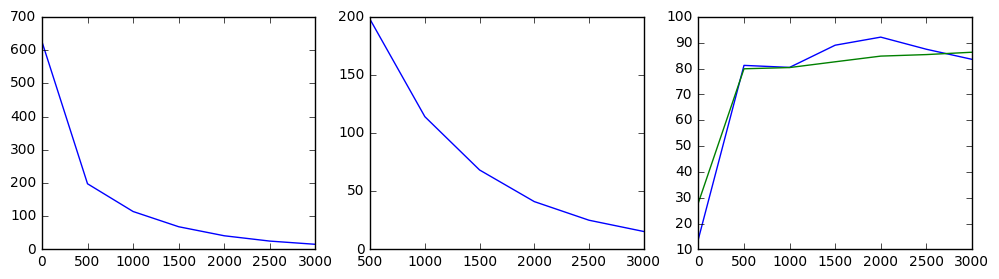

In [145]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12.0, 3.0)

def plot_training_nums(training_nums):
    fig, axs = plt.subplots(1, 3)
    axs[0].plot([tn['step'] for tn in training_nums], [tn['loss'] for tn in training_nums])
    axs[1].plot([tn['step'] for tn in training_nums[1:]], [tn['loss'] for tn in training_nums[1:]])
    axs[2].plot([tn['step'] for tn in training_nums], [tn['training_accuracy'] for tn in training_nums])
    axs[2].plot([tn['step'] for tn in training_nums], [tn['validation_accuracy'] for tn in training_nums])
    plt.show()

plot_training_nums(training_nums)

Now let's try with two hidden layers.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 300]
0 0.05000 | 500 0.04950 | 1000 0.04901 | 1500 0.04853 | 2000 0.04804 | 2500 0.04757 | 3000 0.04710 | 
Test accuracy: 64.4%


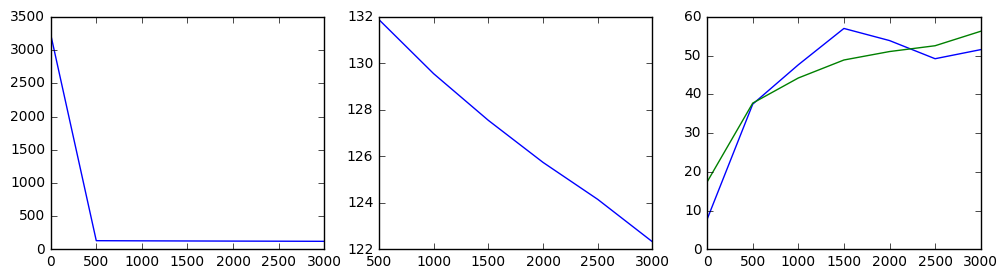

In [149]:
plot_training_nums(run_big_nn_graph(
    0.0003, [1024, 300], 
    starter_learning_rate=0.05, 
    decay_rate=0.96, 
    decay_steps=2048))

That looks not terrible -- it looks like we might get a good result if we were to continue letting it run. Let's try the exact same params, but with a higher learning rate.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 300]
0 0.10000 | 500 0.09901 | 1000 0.09802 | 1500 0.09705 | 2000 0.09609 | 2500 0.09514 | 3000 0.09419 | 
Test accuracy: 10.0%


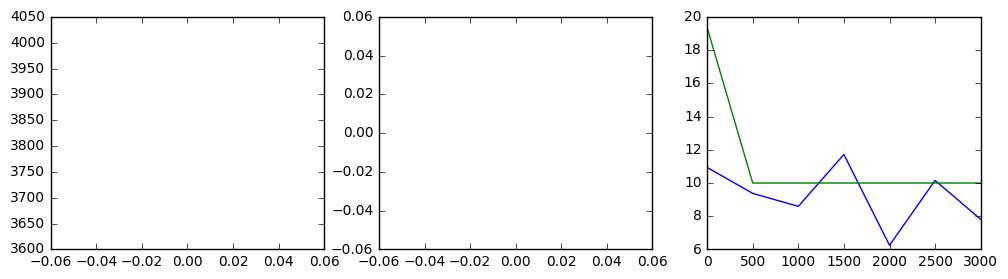

In [150]:
plot_training_nums(run_big_nn_graph(
    0.0003, [1024, 300], 
    starter_learning_rate=0.1, 
    decay_rate=0.96, 
    decay_steps=2048))

Ouch, looks like a learning rate of 0.1 is too high. Let's go back to 0.05, and reduce the l2_beta parameter.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 300]
0 0.05000 | 500 0.04950 | 1000 0.04901 | 1500 0.04853 | 2000 0.04804 | 2500 0.04757 | 3000 0.04710 | 
Test accuracy: 22.7%


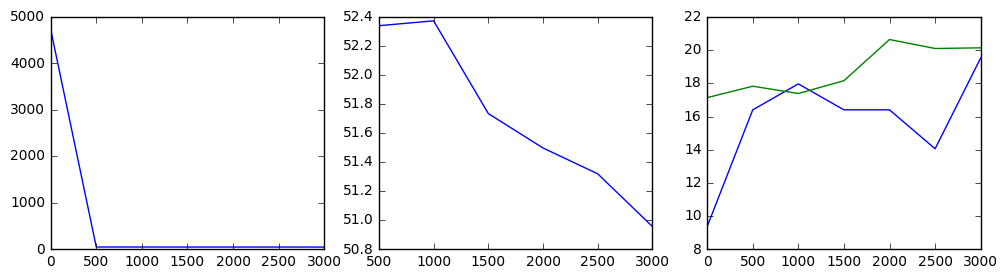

In [152]:
plot_training_nums(run_big_nn_graph(
    0.0001, [1024, 300], 
    starter_learning_rate=0.05, 
    decay_rate=0.96, 
    decay_steps=2048))

Looks like decreasing the l2_beta param to 0.0001 maybe wasn't a good idea. Let's try increasing it:

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 300]
0 0.05000 | 500 0.04950 | 1000 0.04901 | 1500 0.04853 | 2000 0.04804 | 2500 0.04757 | 3000 0.04710 | 
Test accuracy: 51.6%


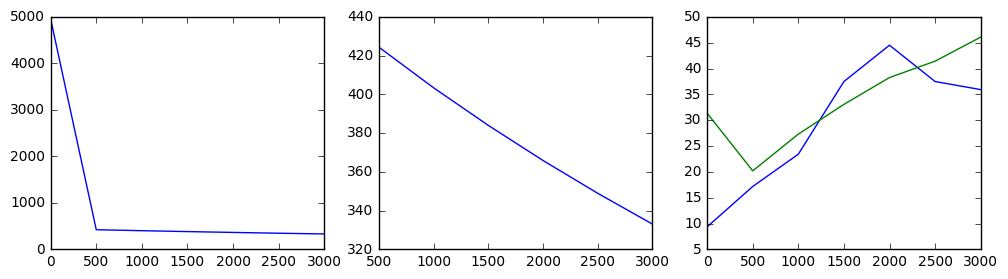

In [153]:
plot_training_nums(run_big_nn_graph(
    0.001, [1024, 300], 
    starter_learning_rate=0.05, 
    decay_rate=0.96, 
    decay_steps=2048))

Okay, looks like l2_beta of 0.0003 gave us the best results. Let's go back to this beta value but increase the number of steps. These experiments take a long time to run, so I just want to try two more: more steps with an l2_beta of 0.0003, and more steps with an l2_beta of 0.001.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 300]
0 0.05000 | 500 0.04950 | 1000 0.04901 | 1500 0.04853 | 2000 0.04804 | 2500 0.04757 | 3000 0.04710 | 3500 0.04663 | 4000 0.04617 | 4500 0.04571 | 5000 0.04526 | 5500 0.04481 | 6000 0.04436 | 6500 0.04392 | 7000 0.04349 | 7500 0.04306 | 8000 0.04263 | 8500 0.04221 | 9000 0.04179 | 9500 0.04137 | 10000 0.04096 | 10500 0.04056 | 11000 0.04015 | 11500 0.03976 | 12000 0.03936 | 12500 0.03897 | 13000 0.03859 | 13500 0.03820 | 14000 0.03782 | 14500 0.03745 | 15000 0.03708 | 15500 0.03671 | 16000 0.03635 | 16500 0.03599 | 17000 0.03563 | 17500 0.03528 | 18000 0.03493 | 18500 0.03458 | 19000 0.03424 | 19500 0.03390 | 
Test accuracy: 78.1%


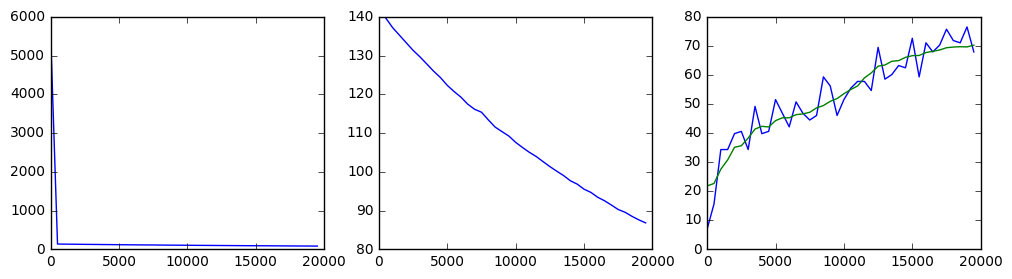

In [154]:
plot_training_nums(run_big_nn_graph(
    0.0003, [1024, 300], 
    num_steps=20000,
    starter_learning_rate=0.05, 
    decay_rate=0.96, 
    decay_steps=2048))

Okay, this is not great. These take a very long time to run also. I'm going to try increasing the learning rate, going back to the old number of steps.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 300]
0 0.07000 | 500 0.06930 | 1000 0.06862 | 1500 0.06794 | 2000 0.06726 | 2500 0.06660 | 3000 0.06594 | 
Test accuracy: 44.5%


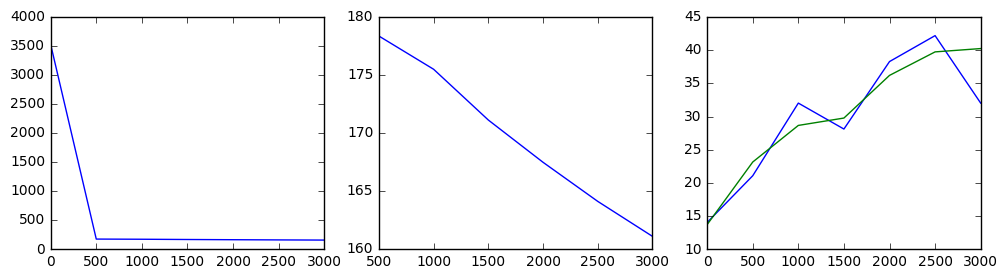

In [155]:
plot_training_nums(run_big_nn_graph(
    0.0003, [1024, 300], 
    starter_learning_rate=0.07, 
    decay_rate=0.96, 
    decay_steps=2048))

Not great. Okay, one more experiment before we stop: move learning rate back to 0.05, but increase l2_beta to 0.001, and run with many (20k) steps.

hidden layer 0 will have weight dimensions [784, 1024]
hidden layer 1 will have weight dimensions [1024, 300]
0 0.05000 | 500 0.04950 | 1000 0.04901 | 1500 0.04853 | 2000 0.04804 | 2500 0.04757 | 3000 0.04710 | 3500 0.04663 | 4000 0.04617 | 4500 0.04571 | 5000 0.04526 | 5500 0.04481 | 6000 0.04436 | 6500 0.04392 | 7000 0.04349 | 7500 0.04306 | 8000 0.04263 | 8500 0.04221 | 9000 0.04179 | 9500 0.04137 | 10000 0.04096 | 10500 0.04056 | 11000 0.04015 | 11500 0.03976 | 12000 0.03936 | 12500 0.03897 | 13000 0.03859 | 13500 0.03820 | 14000 0.03782 | 14500 0.03745 | 15000 0.03708 | 15500 0.03671 | 16000 0.03635 | 16500 0.03599 | 17000 0.03563 | 17500 0.03528 | 18000 0.03493 | 18500 0.03458 | 19000 0.03424 | 19500 0.03390 | 
Test accuracy: 87.3%


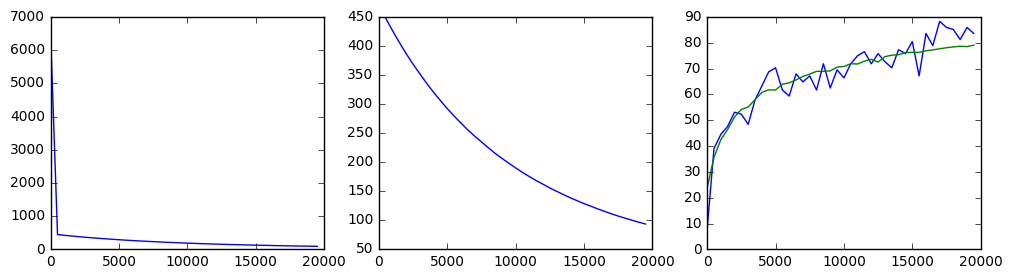

In [156]:
plot_training_nums(run_big_nn_graph(
    0.001, [1024, 300], 
    num_steps=20000,
    starter_learning_rate=0.05, 
    decay_rate=0.96, 
    decay_steps=2048))

Okay, I think that's it for now. I wasn't able to beat the 93.2% I got with a single-layer network using l2 regularization.